# DTSA 5511 Final Project
### Introduction

For my final project I have chosen to tackle an image classification problem presented by a Kaggle [dataset](https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset/data). The images in the dataset are of two different varieties of pistachios: "Siirt" and "Kirmizi", with the goal being to create a neural-network based model capable of reliably differentiating between them.

The general steps of the project will include exploring and pre-processing the data, preparing the model(s), training the models, and evaluating their performance.

All code for this project can be found on my GitHub: https://github.com/nhansendev/DTSA_5511_FinalProject

In [1]:
# Import required modules
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Bulky functions have been moved to separate files for brevity
from constants import SCRIPT_DIR, RANDOM_SEED, RNG
from utils import plot_img_tensor, sum_model_params
from training import Trainer
from data_handling import DataHandler

# For reproducibility
torch.manual_seed(RANDOM_SEED);

# Additional Optimization
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

### Exploratory Data Analysis
Images have been preprocessed into numpy arrays for faster loading compared to loading images one-at-a-time, though this method has high RAM requirements to keep the entire dataset in memory (see "preprocessing.py").

To aid model training the images are normalized after loading so that the color values are in the range -1 to 1, instead of 0 to 255:

In [2]:
# Read data from numpy files
siirt = np.load(os.path.join(SCRIPT_DIR, 'siirt.npy'))
kirmizi = np.load(os.path.join(SCRIPT_DIR, 'kirmizi.npy'))
print(siirt.shape)
print(kirmizi.shape)

(916, 600, 600, 3)
(1232, 600, 600, 3)


We can see that each image is 600x600 pixels, with three color channels (red, green, blue). There are 916 siirt images and 1232 kirmizi images, which will be independently sampled during training to ensure equal representation in each batch.

If we plot a few examples of each type of pistachio:

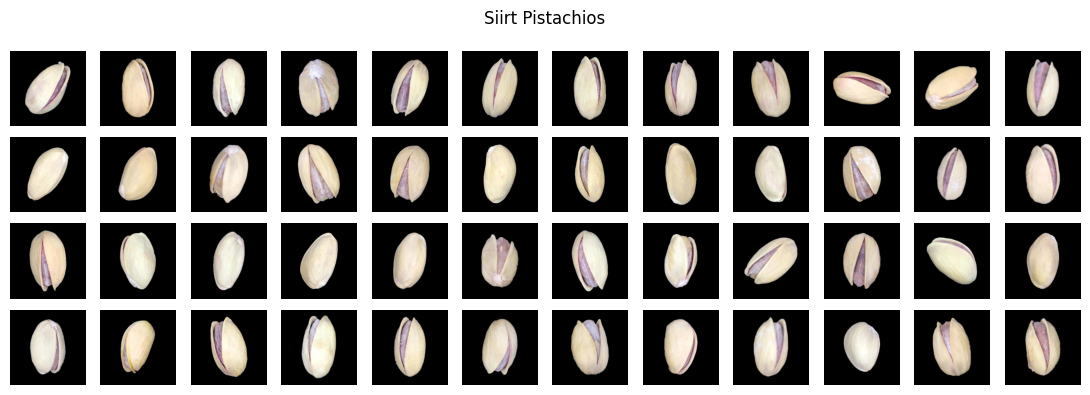

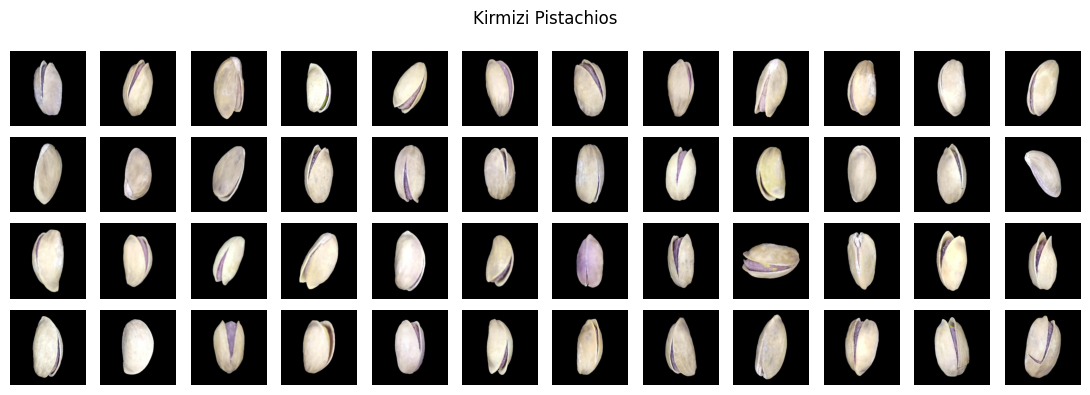

In [3]:
# Plot example images of each type
plot_img_tensor(siirt, "Siirt Pistachios", 4, 12, 11, 4)
plot_img_tensor(kirmizi, "Kirmizi Pistachios", 4, 12, 11, 4)

From the example images we can see that the differences between the two types are subtle, and that the images were taken at various orientations. 

By looking at the mean and standard deviation of the pixels across all images we can get an idea of where most variations occur:

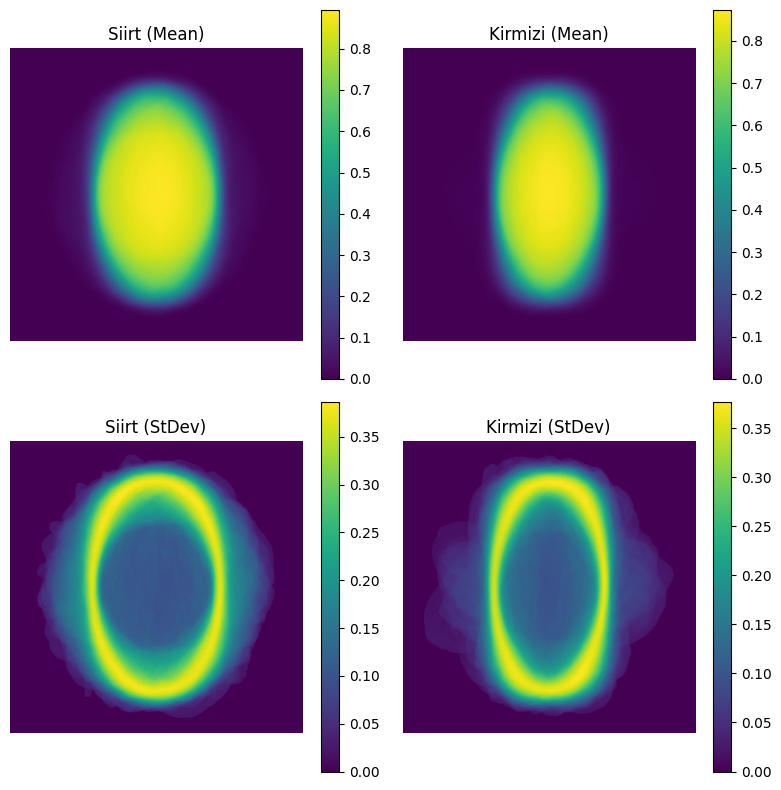

In [4]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)

# Adjust data range to [0 to 1], then take mean of channel and batch axes
im = axs[0, 0].imshow(np.mean(siirt/255, axis=(3, 0)))
plt.colorbar(im)
im2 = axs[0, 1].imshow(np.mean(kirmizi/255, axis=(3, 0)))
plt.colorbar(im2)

# Adjust data range to [0 to 1], then take st.dev. of channel and batch axes
im = axs[1, 0].imshow(np.std(siirt/255, axis=(3, 0)))
plt.colorbar(im)
im2 = axs[1, 1].imshow(np.std(kirmizi/255, axis=(3, 0)))
plt.colorbar(im2)

axs[0, 0].set_title('Siirt (Mean)')
axs[0, 1].set_title('Kirmizi (Mean)')
axs[1, 0].set_title('Siirt (StDev)')
axs[1, 1].set_title('Kirmizi (StDev)')

axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')

plt.tight_layout()

plt.show()

There are several observations that could be made from these plots:
1. Most images of the pistachios are with them oriented "upright" with their long axis aligned vertically
2. Images of the Siirt pistachios may appear in other orientations besides "upright" more frequently than Kirmizi
3. Siirt pistachios may be wider in general than Kirmizi, but with similar height (assuming a fixed camera distance)

Histograms of the average color values per channel are plotted below:

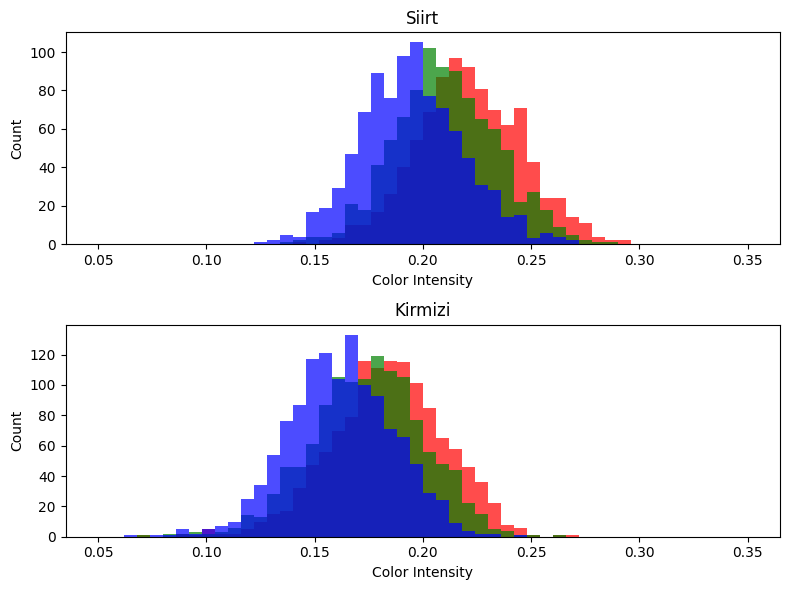

In [5]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(8, 6)
axs = fig.axes

# Adjust data range to [0 to 1], then take mean of channel and batch axes
tmp1 = np.mean(siirt/255, axis=(1, 2))
tmp2 = np.mean(kirmizi/255, axis=(1, 2))
bins = 50
for i in range(3):
    axs[0].hist(tmp1[:, i], bins=bins, range=(0.05, 0.35), histtype='bar', color='rgb'[i], alpha=0.7)
    axs[1].hist(tmp2[:, i], bins=bins, range=(0.05, 0.35), histtype='bar', color='rgb'[i], alpha=0.7)

axs[0].set_title('Siirt')
axs[1].set_title('Kirmizi')

for a in axs:
    a.set_xlabel('Avg. Color Intensity')
    a.set_ylabel('Count')

plt.tight_layout()

plt.show()

We can see that the distributions of colors for Siirt and Kirmizi are very similar, but shifted. This indicates that the average Kirmizi image is darker than the average Siirt image, which makes sense if Siirt pistachios are on average larger (or their picture are more "zoomed-in") so that less of the dark background is visible. Comparing the example images, it does make sense that their color distributions would be similar since their color patterns are subjectively very similar. 

### Data Augmentations
Data augmentations can be used to help the model adapt to the variations between images, including:
- Random Rotation
- Random Horizontal / Vertical Flip
- Random Resized Crop

The rotations and flips should help with the variable orientations in the images, while the resized crop will randomly "zoom-in" and shift the images before scaling them back to the starting size. This can help account for pistachios being shifted between images, variations in image quality, and size variations between pistachios. However, as noted in the data exploration the Siirt pistachios appear to be larger on average than the Kirmizi, suggesting that the resized crop may actually interfere with the model recognizing this difference. The augmentations will be applied in different combinations to evaluate this idea.

It may also be helpful to apply color-based augmentations, assuming that absolute color values are less important for identification than the color patterns within the images.
These augmentations will also be evaluated separately from the others to determine their effectiveness:
- Color Jitter (random brightness, contrast, saturation, and hue variation)

Prepare datasets and transformations:

In [3]:
# Split into training and validation sets
ratio = 0.9
train_idxs_s = torch.BoolTensor(
    RNG.choice(2, len(siirt), True, [1 - ratio, ratio])
)
train_idxs_k = torch.BoolTensor(
    RNG.choice(2, len(kirmizi), True, [1 - ratio, ratio])
)

# Create training data handler for performing augmentations
siirt_train = siirt[train_idxs_s]
kirmizi_train = kirmizi[train_idxs_k]

dataset = DataHandler(siirt_train, kirmizi_train)

# Create validation data set
siirt_test = torch.FloatTensor(siirt[~train_idxs_s]/127.5-1).permute(0, 3, 1, 2)
kirmizi_test = torch.FloatTensor(kirmizi[~train_idxs_k]/127.5-1).permute(0, 3, 1, 2)
valid_data = torch.cat((siirt_test, kirmizi_test)).cuda()
valid_labels = np.array([0]*len(siirt_test)+[1]*len(kirmizi_test))

print(siirt_train.shape, kirmizi_train.shape)
print(valid_data.shape, valid_labels.shape)

(837, 600, 600, 3) (1079, 600, 600, 3)
torch.Size([232, 3, 600, 600]) (232,)


Example augmentations:

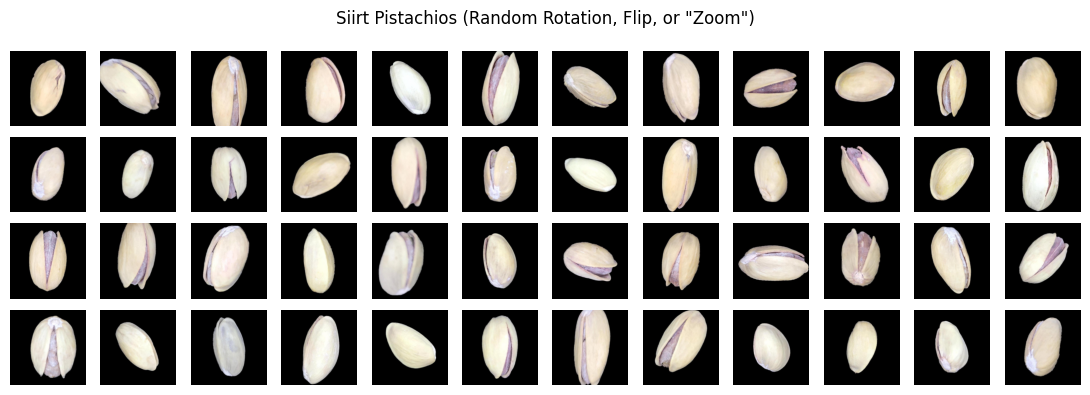

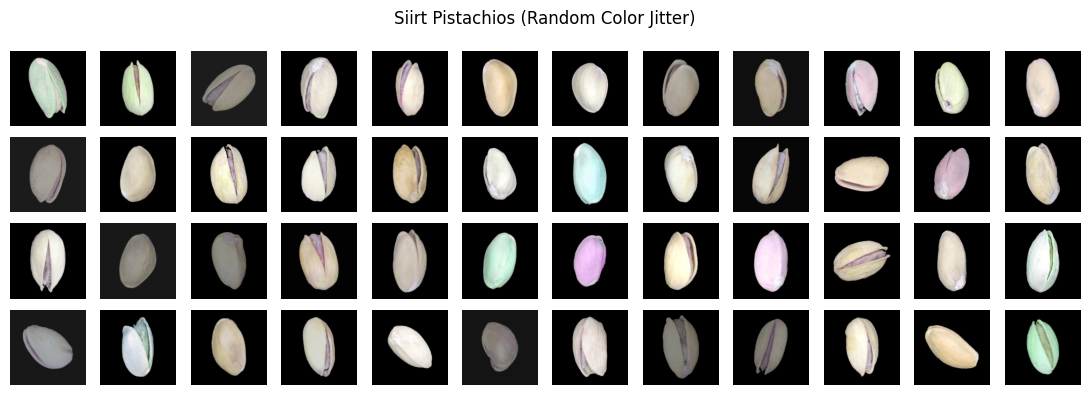

In [7]:
data = dataset.make_sample(48, True, True, True, False)
plot_img_tensor(data, 'Siirt Pistachios (Random Rotation, Flip, or "Zoom")', 4, 12, 11, 4)

data = dataset.make_sample(48, True, False, False, True)
plot_img_tensor(data, "Siirt Pistachios (Random Color Jitter)", 4, 12, 11, 4)

### Model Architecture
Based on the discriminator in [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) the model topology is as follows:
1. A stack of down-sampling convolutional blocks encode the images into a more compact latent representation
2. Optional Residual Blocks, which increase the depth of the model to provide more capacity for complex feature extraction while mitigating the risk of exploding or vanishing gradients
3. Features are collapsed to a single channel (via convolution), followed by adaptive pooling (to set a fixed NxN matrix size from "any" input size) and a Linear layer to adapt to the required category prediction (0 to 1 output)

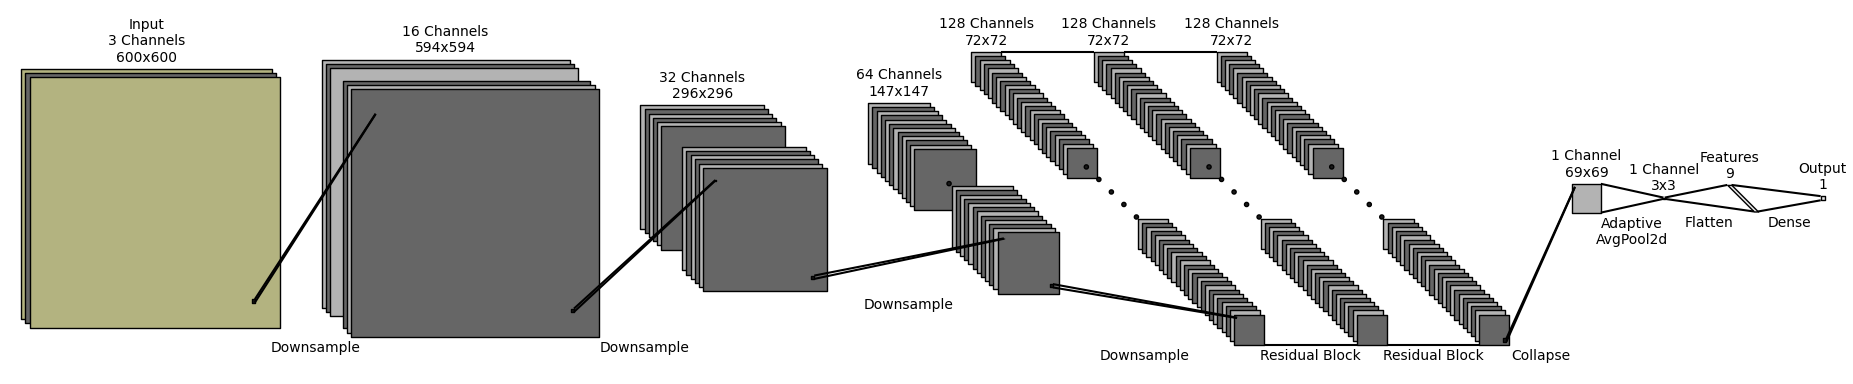

The convolutional blocks have the following structure:

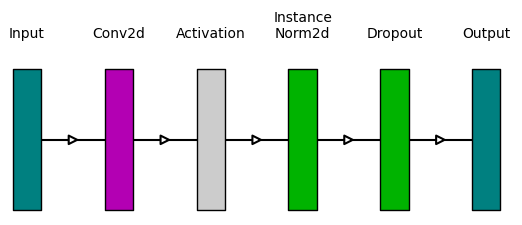

The residual blocks have the following structure:

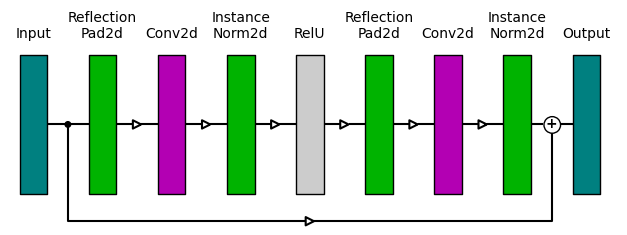


Images generated with: https://github.com/nhansendev/PyDrawNet

### Performance Metrics
During model training the [Binary Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) of the predicted and real classifications will be used as the loss function, which is applicable due to there being only two possible classification options (0 for Siirt, 1 for Kirmizi).

The validation performance of the model will be evaluated using the [F1-Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). This will provide a better representation of model performance than "accuracy", since it requires that both the false-positive and false-negative rates are low to achieve a good score.

### Hyperparameter Variations

Several variations of model hyperparameters and data augmentation will be evaluated to determine the effect of each on model performance:
1. Varying the size of the model through the number of convolution blocks and residual blocks
2. Varying the size of the kernel used in the convolutions
3. Adding dropout for additional regularization
4. The three groups of augmentation types
5. Applying the same augmentation across a batch of images, or a random augmentation to each image in the batch
6. Instance normalization vs Batch normalization

In [4]:
columns = ['Use Geo Aug', 'Use Crop Aug', 'Use Color Aug', 'Batched Aug', 'Norm Type', 'Model Size', 'Kernel Size', 'Model Depth', 'Model Layers', "Dropout", 'Parameters', 'Train Loss', 'Valid F1 Score']
default_values = [False, False, False, True, 'Instance', 'S', 2, 3, 0, 0, 'TBD', 'TBD', 'TBD']

runs_dict = {columns[i]: [default_values[i]] for i in range(len(columns))}

def insert_row(dct):
    for i, c in enumerate(columns):
        if c in dct.keys():
            runs_dict[c].append(dct[c])
        else:
            runs_dict[c].append(default_values[i])

insert_row({'Model Size': "M", "Model Depth": 4, 'Model Layers': 3}) 
insert_row({'Model Size': "L", "Model Depth": 5, 'Model Layers': 5}) 
insert_row({'Kernel Size': 4})
insert_row({'Kernel Size': 6})
insert_row({'Dropout': 0.5})
insert_row({'Use Geo Aug': True})
insert_row({'Use Crop Aug': True})
insert_row({'Use Color Aug': True})
insert_row({'Use Geo Aug': True, "Batched Aug": False})
insert_row({'Norm Type': 'Batch'})

runs_table = pd.DataFrame(runs_dict)
runs_table

,Use Geo Aug,Use Crop Aug,Use Color Aug,Batched Aug,Norm Type,Model Size,Kernel Size,Model Depth,Model Layers,Parameters,Train Loss,Valid F1 Score
0,False,False,False,True,Instance,S,2,3,0,TBD,TBD,TBD
1,False,False,False,True,Instance,M,2,4,3,TBD,TBD,TBD
2,False,False,False,True,Instance,L,2,5,5,TBD,TBD,TBD
3,False,False,False,True,Instance,S,4,3,0,TBD,TBD,TBD
4,False,False,False,True,Instance,S,6,3,0,TBD,TBD,TBD
5,True,False,False,True,Instance,S,2,3,0,TBD,TBD,TBD
6,False,True,False,True,Instance,S,2,3,0,TBD,TBD,TBD
7,False,False,True,True,Instance,S,2,3,0,TBD,TBD,TBD
8,True,False,False,False,Instance,S,2,3,0,TBD,TBD,TBD
9,False,False,False,True,Batch,S,2,3,0,TBD,TBD,TBD


Model sizes are determined by the number of parameters, which are limited for Large models by available GPU RAM. Tradeoffs between batch sizes and number of training iterations may be required for larger models.

In [9]:
# Example of model architecture:
Trainer(dataset, valid_data, valid_labels, depth=3, res_layers=0, show_summary=True);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
|    └─CNNLayer: 2-1                     [-1, 16, 594, 594]        2,368
|    └─CNNLayer: 2-2                     [-1, 32, 296, 296]        8,224
|    └─CNNLayer: 2-3                     [-1, 64, 147, 147]        32,832
|    └─CNNLayer: 2-4                     [-1, 128, 72, 72]         131,200
|    └─CNNLayer: 2-5                     [-1, 1, 69, 69]           2,049
|    └─AdaptiveAvgPool2d: 2-6            [-1, 1, 3, 3]             --
|    └─Flatten: 2-7                      [-1, 9]                   --
|    └─Linear: 2-8                       [-1, 2]                   20
Total params: 176,693
Trainable params: 176,693
Non-trainable params: 0
Total mult-adds (M): 0.53
Input size (MB): 4.12
Forward/backward pass size (MB): 0.00
Params size (MB): 0.67
Estimated Total Size (MB): 4.79


#### Running Iterations

Index: 0


100%|██████████| 6000/6000 [02:15<00:00, 44.27it/s]


Final Loss: 3.69e-01


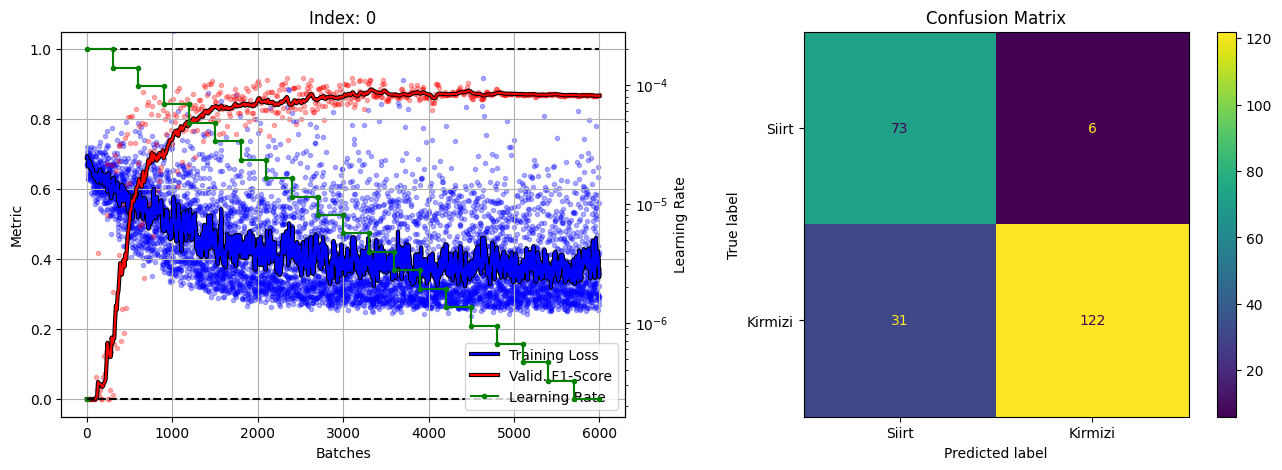

Index: 1


100%|██████████| 6000/6000 [03:43<00:00, 26.88it/s]


Final Loss: 2.81e-01


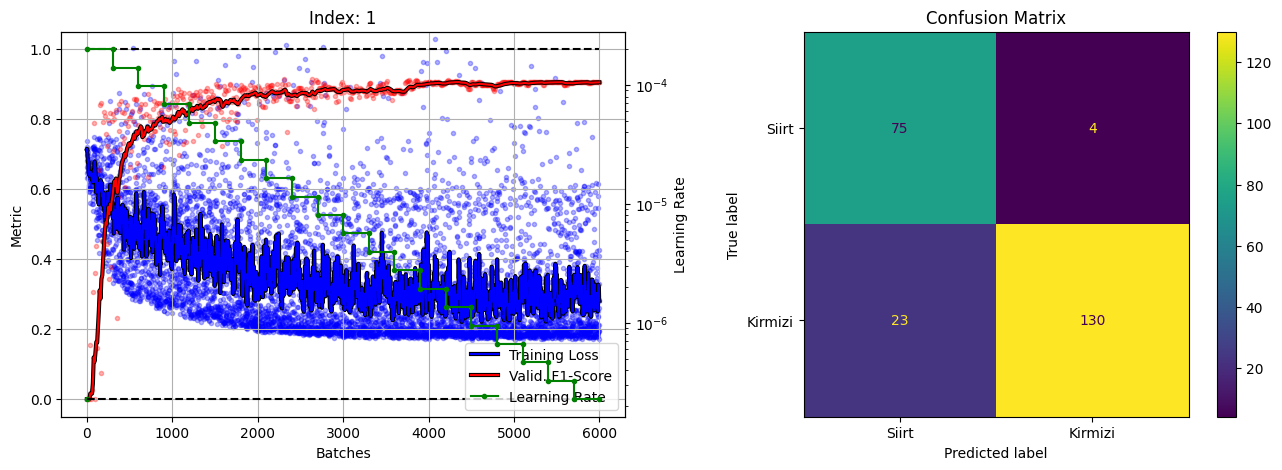

Index: 2


100%|██████████| 6000/6000 [04:54<00:00, 20.37it/s]


Final Loss: 1.53e-01


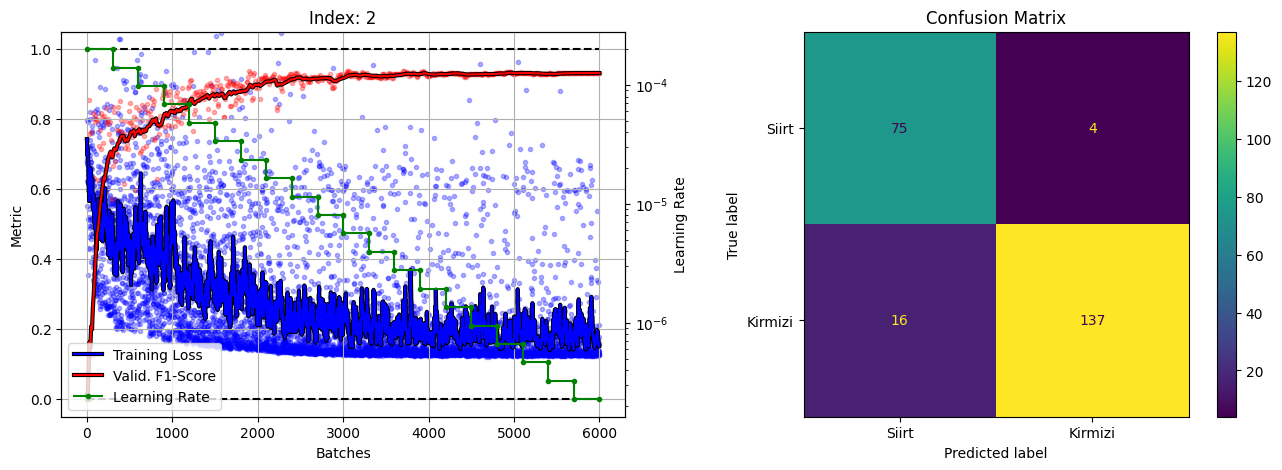

Index: 3


 92%|█████████▏| 5491/6000 [01:58<00:11, 45.81it/s]

In [ ]:
for index, row in runs_table.iterrows():
    # Cleanup previous run
    try:
        del TR
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()

    columns = ['Use Geo Aug', 'Use Crop Aug', 'Use Color Aug', 'Batched Aug', 'Norm Type', 'Model Size', 'Kernel Size', 'Model Depth', 'Model Layers', "Dropout", 'Parameters', 'Train Loss', 'Valid F1 Score']

    print(f'Index: {index}')
    dataset.use_geo_aug = row['Use Geo Aug']
    dataset.use_crop_aug = row['Use Crop Aug']
    dataset.use_color_aug = row['Use Color Aug']
    dataset.batch_size = 4
    dataset.batch_aug = row['Batched Aug']
    TR = Trainer(dataset, valid_data, valid_labels, depth=row["Model Depth"], res_layers=row['Model Layers'], dropout=row['Dropout'], inst_norm=row['Norm Type']=='Instance', show_summary=False)
    runs_table.loc[index, 'Parameters'] = sum_model_params(TR.classifier)
    TR.train(6000)
    runs_table.loc[index, 'Train Loss'] = TR.loss_hist[-1]
    runs_table.loc[index, 'Valid F1 Score'] = TR.best_score
    TR.plot_hist(title=f'Index: {index}', width=16, height=5, show_CM=True)

### Results

In [6]:
runs_table

,Use Geo Aug,Use Crop Aug,Use Color Aug,Batched Aug,Norm Type,Model Size,Kernel Size,Padding,Model Depth,Model Layers,Parameters,Train Loss,Valid F1 Score
0,False,False,False,True,Instance,S,4,2,3,0,176693,0.305298,0.941176
1,False,False,False,True,Instance,M,4,2,4,3,6996277,0.086899,0.947712
2,False,False,False,True,Instance,L,4,2,5,5,44753205,0.127762,0.967105
3,False,False,False,True,Instance,M,2,1,3,3,1750325,0.107224,0.951456
4,False,False,False,False,Instance,M,4,2,3,3,1750325,0.281326,0.942761
5,True,False,False,True,Instance,M,4,2,3,3,1750325,0.268494,0.919094
6,False,True,False,True,Instance,M,4,2,3,3,1750325,0.324371,0.953333
7,False,False,True,True,Instance,M,4,2,3,3,1750325,0.341705,0.922078
8,False,False,False,True,Batch,M,4,2,3,3,1752311,0.073948,0.956522


### Conclusion

### References
Pistachio Image Dataset. (2022, March 28). Kaggle. https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset/data
